Using as the input the output of the detection pipeline as a mask to process and output 4 corners of the flayble area

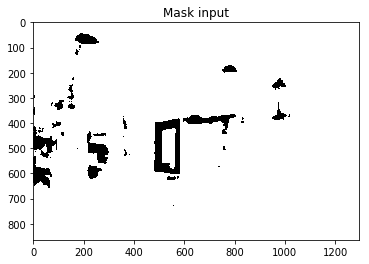

In [43]:
from matplotlib import pyplot as plt
import imutils
import numpy as np
import cv2


output_folder_path='/Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/'
#output_image_test=output_folder_path+'0024.jpg' # Good!
#output_image_test=output_folder_path+'0041.jpg' # Good!
#output_image_test=output_folder_path+'0046.jpg' # Good!
#output_image_test=output_folder_path+'0068.jpg' # Good!
#output_image_test=output_folder_path+'0095.jpg' # Good!
output_image_test=output_folder_path+'0115.jpg'

# img = cv2.imread('images/mask.jpg')
img_original = cv2.imread(output_image_test)

img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
img_blur =  cv2.GaussianBlur(img_gray, (5, 5), 0)

#th1 = cv2.threshold(mask_gray,127,255,cv2.THRESH_BINARY)[1]
img_bw = cv2.threshold(img_blur,50,255,cv2.THRESH_BINARY)[1]


result = cv2.cvtColor(img_bw, cv2.COLOR_GRAY2RGB)
plt.imshow(result)
plt.title('Mask input')
plt.show()

## Shape and Corner Detection

### Refs
https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv


Shape: 21 Area 22236 x, y, w, h, corners: 481 381 102 218 122


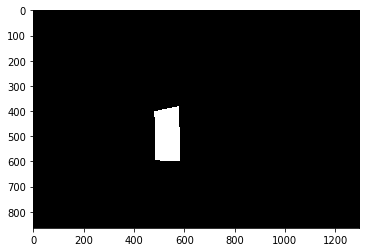

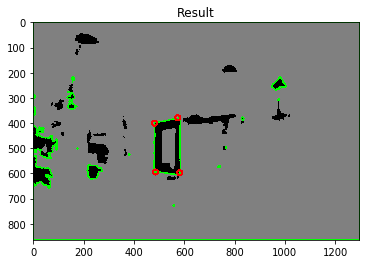

[{'area': 22236, 'centroid': (532, 494), 'corners': array([[647.5075 , 431.4961 ],
       [573.49994, 379.99908],
       [481.35294, 401.52942],
       [485.3889 , 594.6111 ],
       [581.6111 , 597.6111 ]], dtype=float32)}]


In [56]:
img_result = img_original.copy()

results = []

height, width = img.shape[:2]


_min_pixels_size = 60 # 100
_max_pixels_size = height * 0.95


#cnts = cv2.findContours(th1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cv2.findContours(img_bw.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)



for index,c in enumerate(cnts):
    
    # Perform shape approximation
    epsilon = 0.1*cv2.arcLength(c,True) #0.04
    approx = cv2.approxPolyDP(c, epsilon, True)
    
    # 4 sides?
    if (len(approx)==4):
        
        cv2.drawContours(img_result, [c], -1, (0, 255, 0), 5)
        
        (x, y, w, h) = cv2.boundingRect(approx)
        if (w>=_min_pixels_size and h>=_min_pixels_size) and (w<_max_pixels_size and h<_max_pixels_size):
            
            result = {}
            
            area = w * h
            result['area'] = area
            
            print('Shape:',index,'Area', area,'x, y, w, h, corners:',x, y, w, h, len(c))
            
            
            M = cv2.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            
            result['centroid'] = (cx, cy)
            
            # create mask for edge detection
            gray = np.float32(th1)
            mask = np.zeros(gray.shape, dtype="uint8")
            cv2.fillPoly(mask, [approx], (255,255,255))
            
            dst = cv2.cornerHarris(mask,5,3,0.04)
            ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
            dst = np.uint8(dst)
            ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
            corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
            
            result['corners'] = corners
            
            results.append(result)
            
            # Draw circles
            for i in range(1, len(corners)):
                #print(corners[i,0])
                cv2.circle(img_result, (int(corners[i,0]), int(corners[i,1])), 10, (255,0,0), 7)

            #print(corners)
            
            plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))
            plt.show()
            
            
        

plt.imshow(img_result)
plt.title('Result')
plt.show()

print(results)

[[573.49994 379.99908]
 [481.35294 401.52942]
 [485.3889  594.6111 ]
 [581.6111  597.6111 ]]


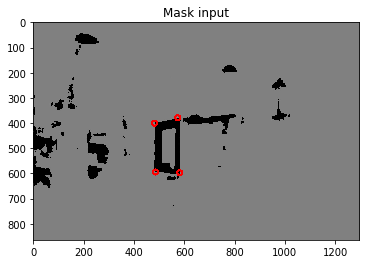

In [51]:
def draw_points_array(image, points):
    for i in range(0, len(points)):
        cv2.circle(image, (int(points[i,0]), int(points[i,1])), 10, (255,0,0), 7)
    return image

def get_inner_area_corners_from_results(results):
    assert len(results)<3, 'I got more than 2 shapes for a gate...'
    if len(results) == 1: 
        inner_shape = results[0]
    else:
        inner_shape = None
        if results[0]['area'] > results[1]['area']:
            inner_shape = results[1]
        else:
            inner_shape = results[0]
    corners = inner_shape['corners'][1:]
    return corners

corners = get_inner_area_corners_from_results(results)
print(corners)

img_solution = draw_points_array(img_original.copy(), corners)

plt.imshow(img_solution)
plt.title('Mask input')
plt.show()

## Corner estimator class

Shape: 0 Area 43472 x, y, w, h, corners: 571 422 209 208 122
Shape: 1 Area 95748 x, y, w, h, corners: 524 369 303 316 131


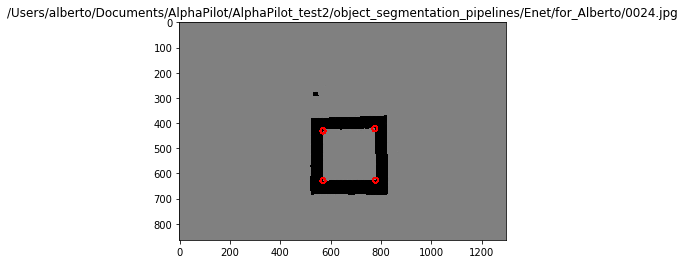

Shape: 21 Area 10318 x, y, w, h, corners: 688 474 67 154 82
Shape: 22 Area 32612 x, y, w, h, corners: 655 429 124 263 155


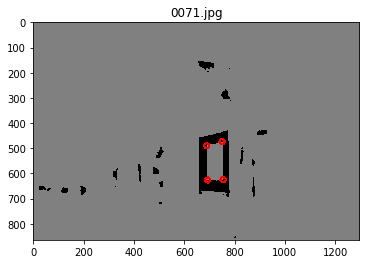

Shape: 3 Area 25857 x, y, w, h, corners: 454 403 153 169 90
Shape: 9 Area 57885 x, y, w, h, corners: 415 364 227 255 127


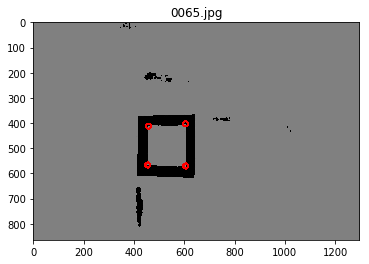

Shape: 36 Area 200846 x, y, w, h, corners: 256 147 431 466 475


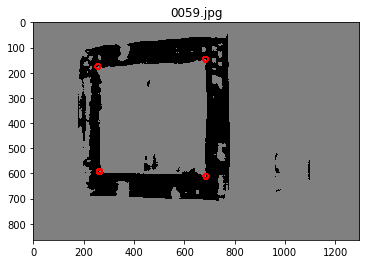

Shape: 0 Area 41184 x, y, w, h, corners: 660 362 198 208 111
Shape: 1 Area 93810 x, y, w, h, corners: 614 307 295 318 124


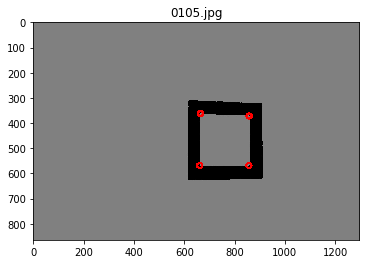

Shape: 0 Area 34010 x, y, w, h, corners: 455 414 179 190 103
Shape: 1 Area 76850 x, y, w, h, corners: 414 363 265 290 106


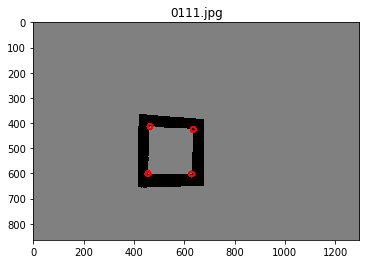

Shape: 1 Area 81776 x, y, w, h, corners: 571 289 269 304 213
Shape: 2 Area 180635 x, y, w, h, corners: 507 215 397 455 233


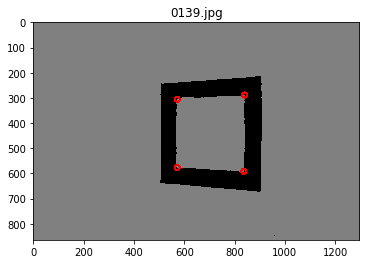

Shape: 15 Area 34686 x, y, w, h, corners: 566 396 141 246 234
Shape: 20 Area 88754 x, y, w, h, corners: 527 320 223 398 281


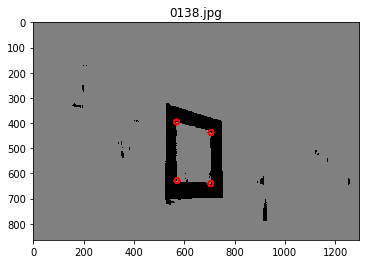

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0110.jpg


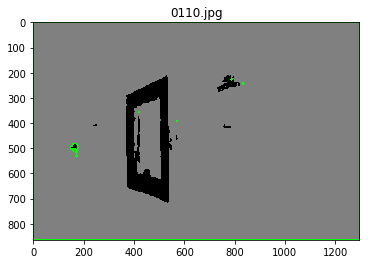

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0104.jpg


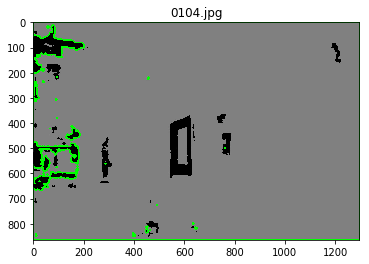

Shape: 15 Area 22940 x, y, w, h, corners: 544 387 124 185 138
Shape: 19 Area 56260 x, y, w, h, corners: 507 333 194 290 152


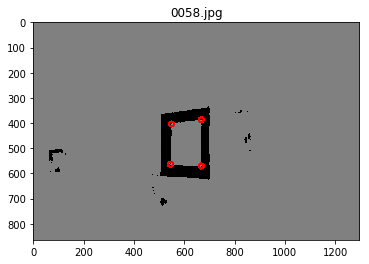

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0064.jpg


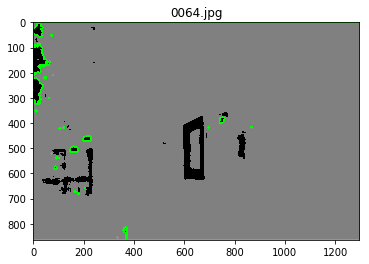

Shape: 2 Area 5670 x, y, w, h, corners: 1128 635 63 90 60


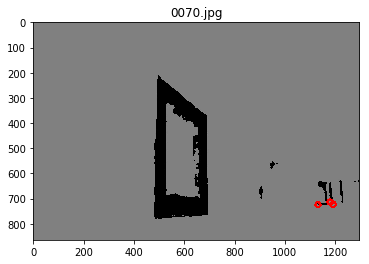

Shape: 6 Area 103776 x, y, w, h, corners: 525 255 276 376 307
Shape: 9 Area 231176 x, y, w, h, corners: 467 164 407 568 398


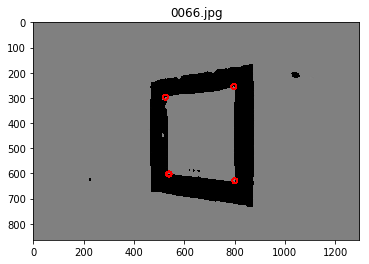

Shape: 1 Area 53823 x, y, w, h, corners: 509 385 233 231 164
Shape: 2 Area 120060 x, y, w, h, corners: 453 328 345 348 130


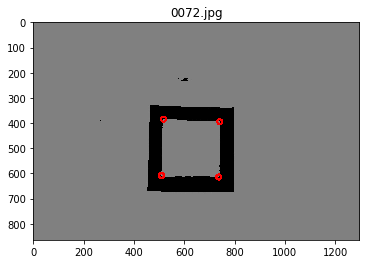

Shape: 11 Area 17407 x, y, w, h, corners: 610 420 103 169 115
Shape: 12 Area 43725 x, y, w, h, corners: 577 368 165 265 127


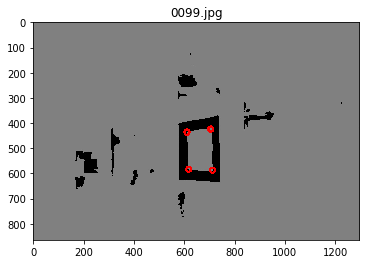

Shape: 3 Area 28236 x, y, w, h, corners: 490 431 156 181 107
Shape: 5 Area 63648 x, y, w, h, corners: 449 387 234 272 107


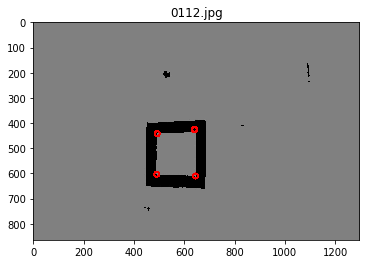

Shape: 12 Area 12996 x, y, w, h, corners: 645 488 114 114 76
Shape: 16 Area 33453 x, y, w, h, corners: 616 456 177 189 127


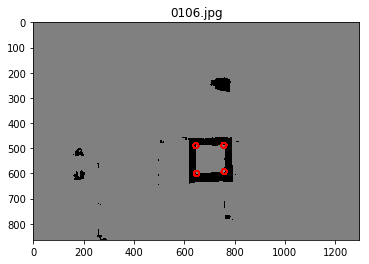

Shape: 10 Area 44697 x, y, w, h, corners: 582 271 141 317 232
Shape: 11 Area 114576 x, y, w, h, corners: 540 174 231 496 325


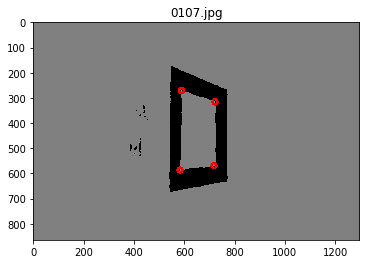

Shape: 33 Area 150144 x, y, w, h, corners: 370 218 391 384 517


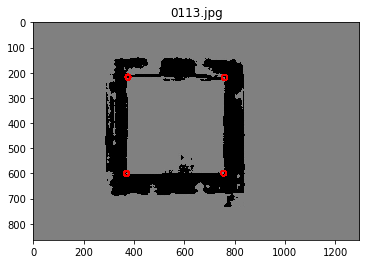

Shape: 36 Area 160740 x, y, w, h, corners: 447 212 380 423 664
Shape: 47 Area 344352 x, y, w, h, corners: 352 107 544 633 495


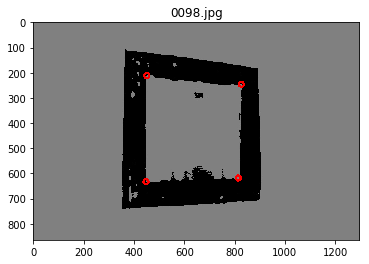

Shape: 15 Area 94466 x, y, w, h, corners: 505 266 298 317 373
Shape: 16 Area 207767 x, y, w, h, corners: 432 195 443 469 344


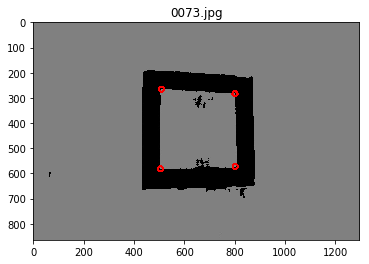

Shape: 47 Area 110653 x, y, w, h, corners: 563 233 283 391 618
Shape: 55 Area 257752 x, y, w, h, corners: 489 114 404 638 520


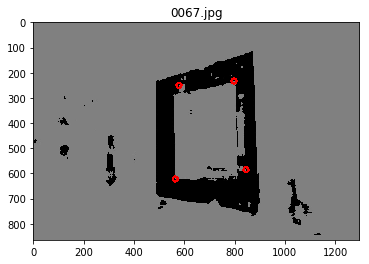

Shape: 10 Area 101908 x, y, w, h, corners: 478 242 292 349 455
Shape: 16 Area 218400 x, y, w, h, corners: 408 155 420 520 396


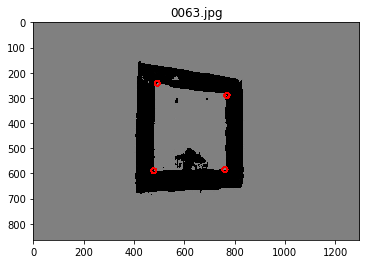

Shape: 6 Area 24600 x, y, w, h, corners: 595 387 150 164 110
Shape: 12 Area 60456 x, y, w, h, corners: 557 332 229 264 119


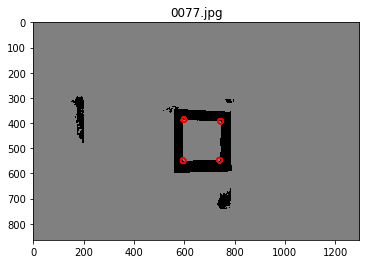

Shape: 6 Area 29406 x, y, w, h, corners: 556 379 174 169 106
Shape: 7 Area 66816 x, y, w, h, corners: 515 336 256 261 146


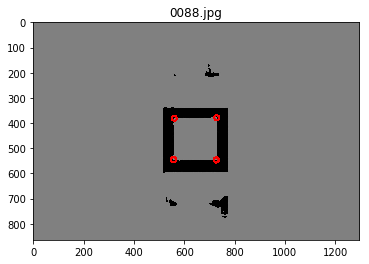

Shape: 4 Area 65021 x, y, w, h, corners: 452 326 253 257 158
Shape: 5 Area 145486 x, y, w, h, corners: 391 260 374 389 176


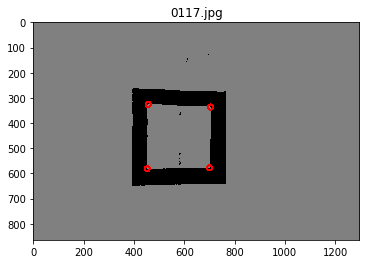

Shape: 94 Area 249410 x, y, w, h, corners: 439 174 509 490 1147


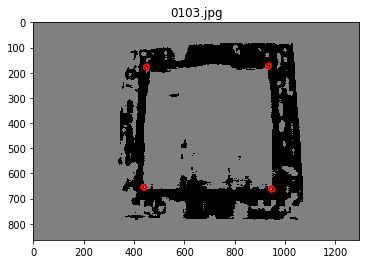

Shape: 21 Area 138646 x, y, w, h, corners: 381 241 362 383 523
Shape: 36 Area 297755 x, y, w, h, corners: 296 151 527 565 608


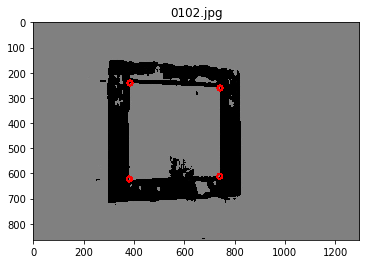

Shape: 3 Area 41612 x, y, w, h, corners: 534 433 206 202 147
Shape: 4 Area 96685 x, y, w, h, corners: 486 383 305 317 120


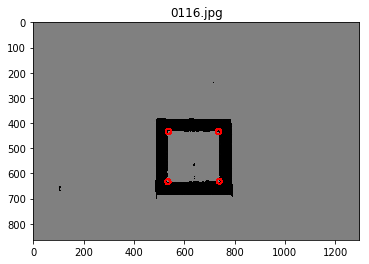

Shape: 8 Area 28672 x, y, w, h, corners: 500 338 128 224 158
Shape: 9 Area 71482 x, y, w, h, corners: 462 274 206 347 205


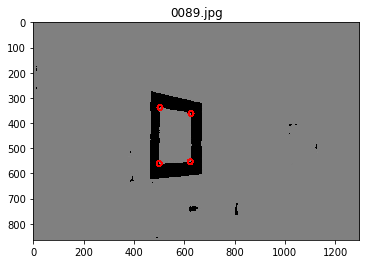

Shape: 9 Area 35960 x, y, w, h, corners: 488 255 124 290 230
Shape: 11 Area 100980 x, y, w, h, corners: 435 166 220 459 288


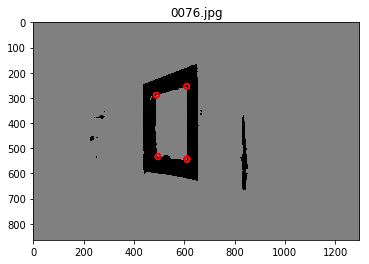

Shape: 20 Area 136340 x, y, w, h, corners: 511 252 340 401 533
Shape: 25 Area 298901 x, y, w, h, corners: 433 153 499 599 499


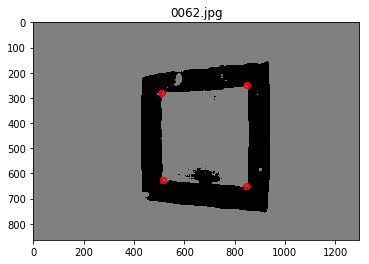

Shape: 26 Area 46216 x, y, w, h, corners: 559 336 212 218 251
Shape: 30 Area 103306 x, y, w, h, corners: 506 282 314 329 276


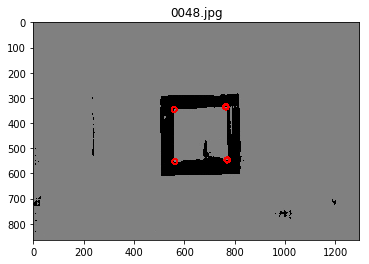

Shape: 13 Area 35673 x, y, w, h, corners: 580 355 141 253 205


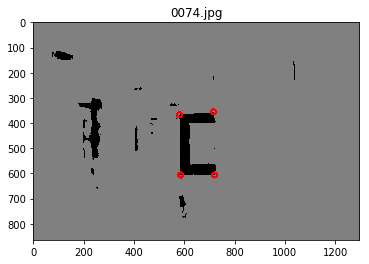

Shape: 6 Area 30624 x, y, w, h, corners: 499 446 176 174 104
Shape: 9 Area 70434 x, y, w, h, corners: 458 397 258 273 125


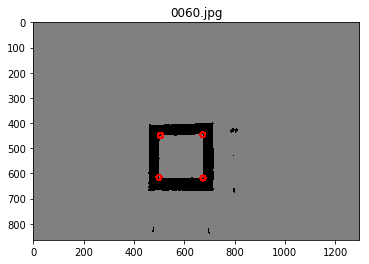

Shape: 19 Area 28000 x, y, w, h, corners: 474 386 112 250 139


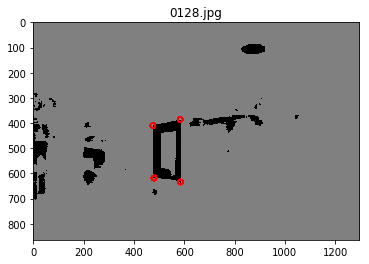

Shape: 7 Area 6020 x, y, w, h, corners: 141 494 70 86 91
Shape: 12 Area 19425 x, y, w, h, corners: 606 403 105 185 139
Shape: 14 Area 45414 x, y, w, h, corners: 568 360 174 261 136
*** I got more than 2 shapes for a gate... 3


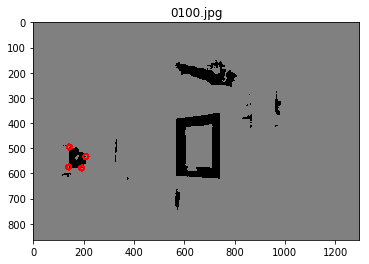

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0114.jpg


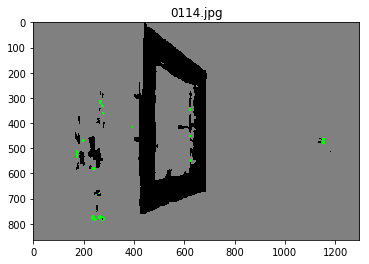

Shape: 21 Area 22236 x, y, w, h, corners: 481 381 102 218 122


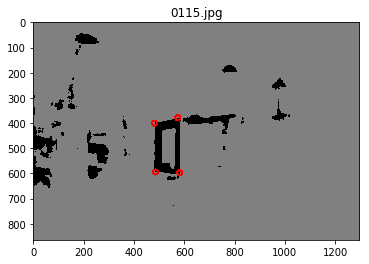

Shape: 42 Area 167958 x, y, w, h, corners: 408 161 387 434 801
Shape: 50 Area 351392 x, y, w, h, corners: 342 57 556 632 719


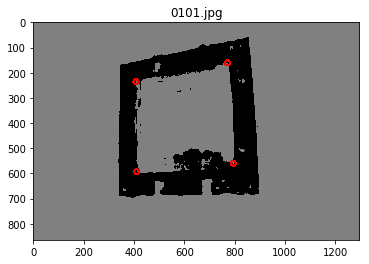

Shape: 0 Area 43259 x, y, w, h, corners: 516 347 181 239 173
Shape: 3 Area 103408 x, y, w, h, corners: 465 283 281 368 171


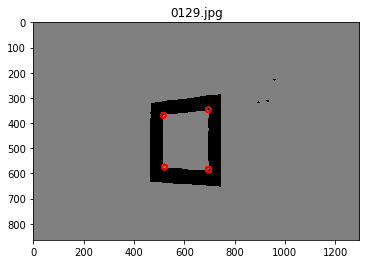

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0061.jpg


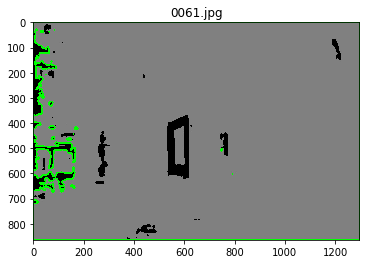

Shape: 36 Area 157212 x, y, w, h, corners: 408 182 396 397 772
Shape: 44 Area 326430 x, y, w, h, corners: 337 97 558 585 489


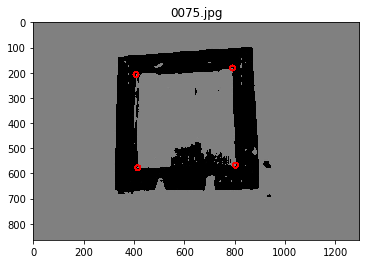

Shape: 17 Area 46768 x, y, w, h, corners: 595 257 148 316 225


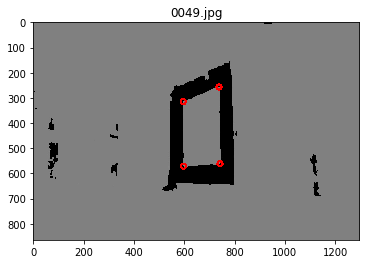

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0012.jpg


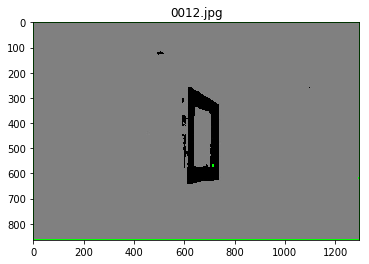

Shape: 12 Area 28810 x, y, w, h, corners: 593 483 134 215 187
Shape: 13 Area 68400 x, y, w, h, corners: 558 419 200 342 217


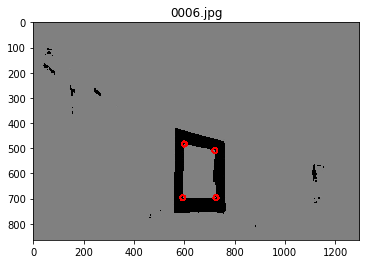

Shape: 6 Area 11297 x, y, w, h, corners: 598 455 79 143 70
Shape: 7 Area 30780 x, y, w, h, corners: 566 416 135 228 118


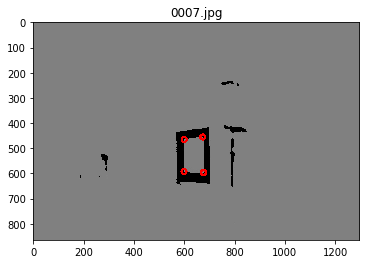

Shape: 27 Area 159490 x, y, w, h, corners: 429 220 389 410 492
Shape: 35 Area 325008 x, y, w, h, corners: 343 135 549 592 549


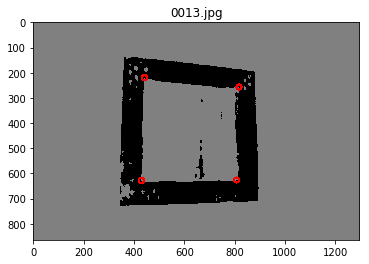

Shape: 18 Area 78547 x, y, w, h, corners: 458 297 229 343 342
Shape: 21 Area 188853 x, y, w, h, corners: 394 210 357 529 352


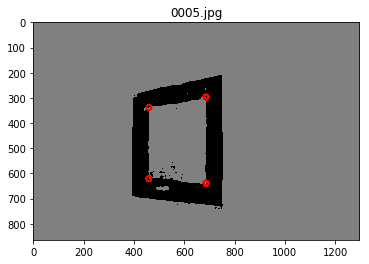

Shape: 10 Area 169644 x, y, w, h, corners: 347 208 402 422 390
Shape: 18 Area 342820 x, y, w, h, corners: 256 116 562 610 552


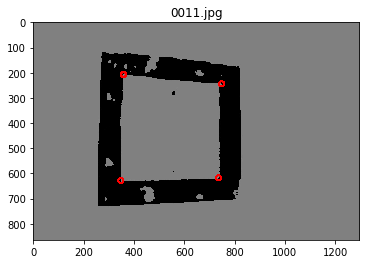

Shape: 4 Area 41000 x, y, w, h, corners: 544 328 164 250 186
Shape: 12 Area 99840 x, y, w, h, corners: 496 258 256 390 194


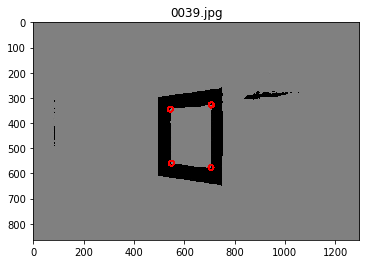

Shape: 15 Area 103362 x, y, w, h, corners: 457 306 321 322 577
Shape: 17 Area 225621 x, y, w, h, corners: 380 224 473 477 314


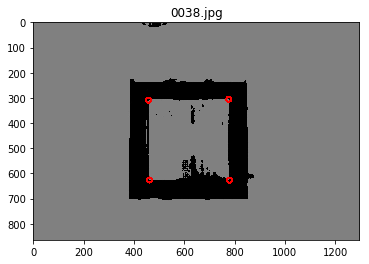

Shape: 26 Area 9500 x, y, w, h, corners: 457 359 100 95 70
Shape: 31 Area 25972 x, y, w, h, corners: 431 317 151 172 117


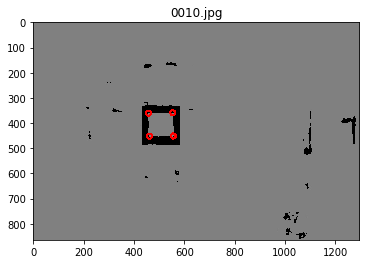

Shape: 6 Area 42486 x, y, w, h, corners: 690 390 194 219 165
Shape: 14 Area 103888 x, y, w, h, corners: 637 328 302 344 299


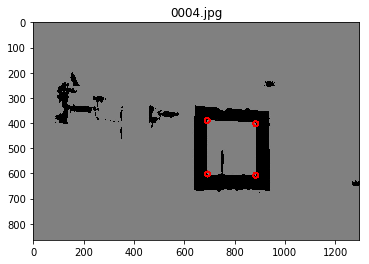

Shape: 5 Area 21230 x, y, w, h, corners: 555 406 110 193 116
Shape: 7 Area 54360 x, y, w, h, corners: 515 350 180 302 161


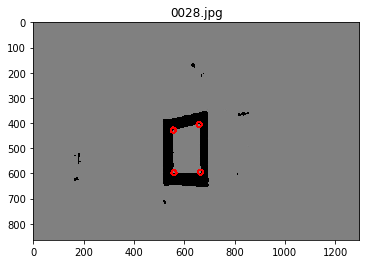

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0000.jpg


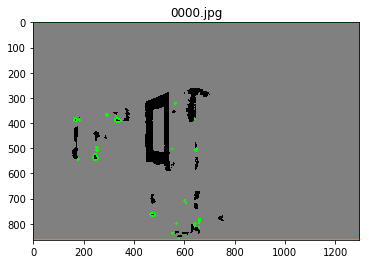

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0014.jpg


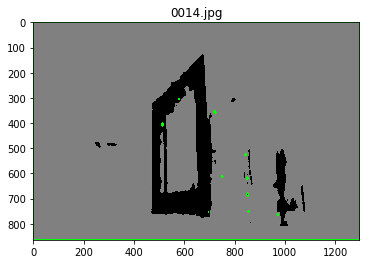

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0148.jpg


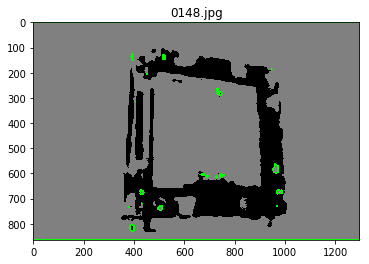

Shape: 19 Area 18144 x, y, w, h, corners: 458 329 108 168 117
Shape: 22 Area 47340 x, y, w, h, corners: 419 283 180 263 127


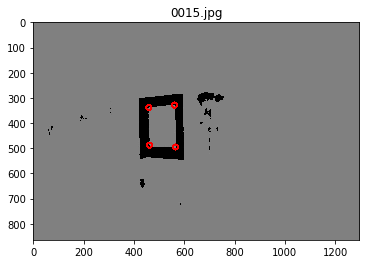

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0001.jpg


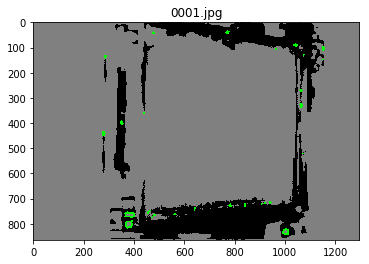

Shape: 1 Area 53856 x, y, w, h, corners: 586 315 204 264 174
Shape: 5 Area 122364 x, y, w, h, corners: 535 251 309 396 206


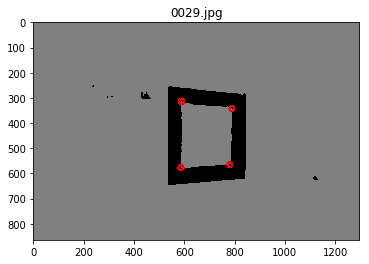

Shape: 3 Area 44100 x, y, w, h, corners: 477 298 210 210 105
Shape: 4 Area 98515 x, y, w, h, corners: 431 245 305 323 146


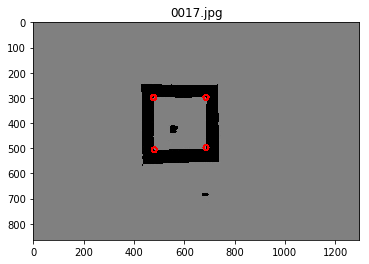

Shape: 26 Area 85692 x, y, w, h, corners: 452 222 222 386 420
Shape: 27 Area 210796 x, y, w, h, corners: 381 92 349 604 419


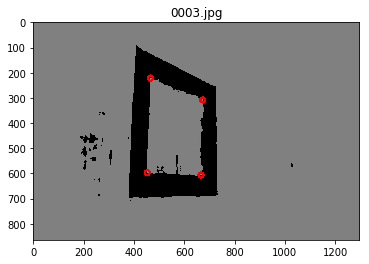

Shape: 9 Area 112558 x, y, w, h, corners: 493 255 334 337 451
Shape: 14 Area 237153 x, y, w, h, corners: 419 179 483 491 409


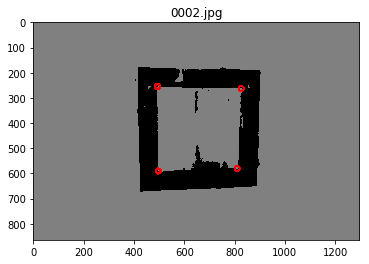

Shape: 26 Area 106092 x, y, w, h, corners: 461 212 252 421 510
Shape: 27 Area 260015 x, y, w, h, corners: 383 67 391 665 539


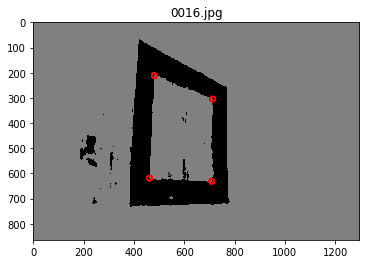

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0033.jpg


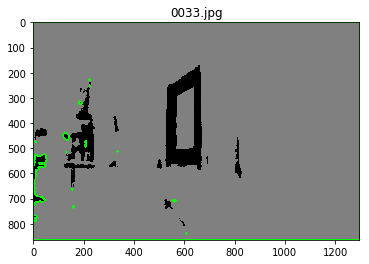

Shape: 13 Area 80864 x, y, w, h, corners: 541 222 224 361 432
Shape: 16 Area 197316 x, y, w, h, corners: 483 106 348 567 504


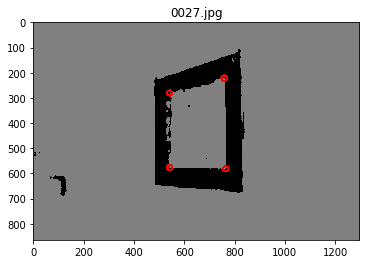

Shape: 30 Area 89270 x, y, w, h, corners: 525 290 226 395 270


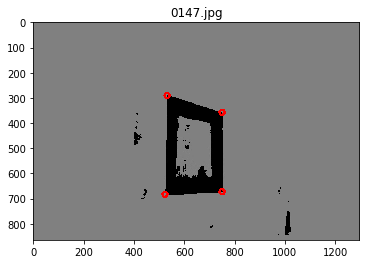

Shape: 2 Area 28860 x, y, w, h, corners: 581 320 148 195 130
Shape: 3 Area 72900 x, y, w, h, corners: 545 263 225 324 205


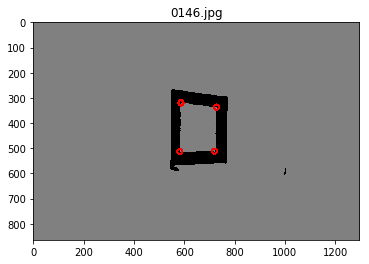

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0026.jpg


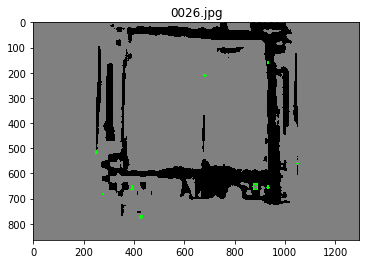

Shape: 32 Area 137268 x, y, w, h, corners: 463 234 372 369 692
Shape: 38 Area 290520 x, y, w, h, corners: 380 151 538 540 390


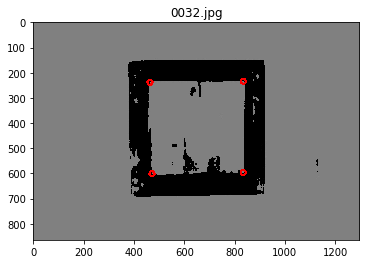

Shape: 0 Area 43472 x, y, w, h, corners: 571 422 209 208 122
Shape: 1 Area 95748 x, y, w, h, corners: 524 369 303 316 131


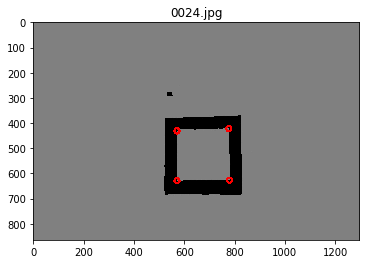

Shape: 4 Area 57159 x, y, w, h, corners: 562 320 219 261 174
Shape: 5 Area 134000 x, y, w, h, corners: 507 247 335 400 279


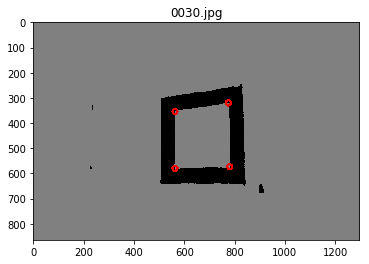

Shape: 26 Area 77679 x, y, w, h, corners: 520 203 189 411 285


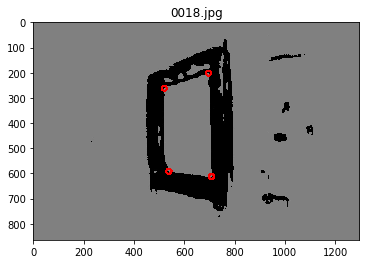

Shape: 26 Area 59584 x, y, w, h, corners: 462 274 196 304 230
Shape: 27 Area 145518 x, y, w, h, corners: 407 190 307 474 272


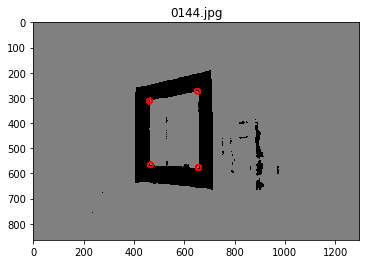

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0145.jpg


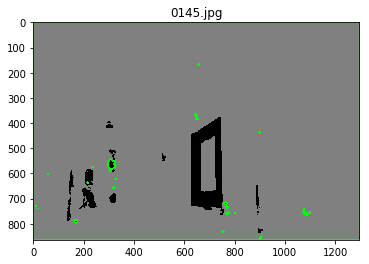

Shape: 3 Area 17574 x, y, w, h, corners: 546 446 101 174 114
Shape: 4 Area 44820 x, y, w, h, corners: 509 396 166 270 175


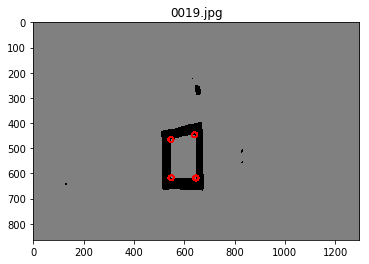

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0031.jpg


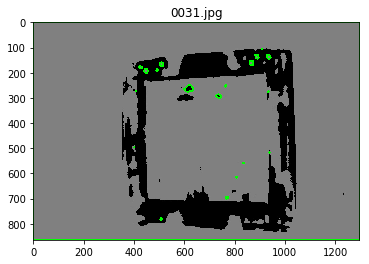

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0025.jpg


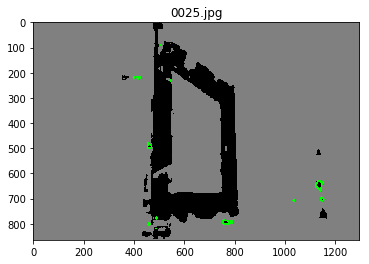

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0009.jpg


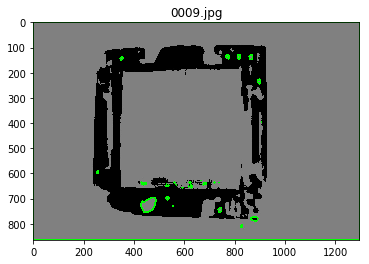

Shape: 10 Area 10728 x, y, w, h, corners: 648 421 72 149 92
Shape: 11 Area 30750 x, y, w, h, corners: 615 376 125 246 149


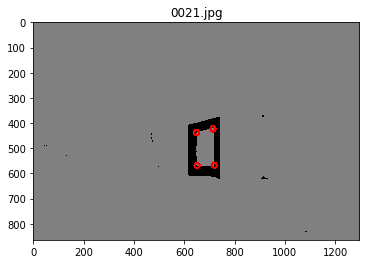

Shape: 45 Area 200701 x, y, w, h, corners: 249 186 419 479 893
Shape: 66 Area 394691 x, y, w, h, corners: 177 98 583 677 782


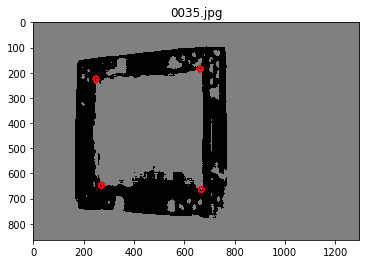

Shape: 2 Area 37440 x, y, w, h, corners: 621 410 180 208 149
Shape: 3 Area 83160 x, y, w, h, corners: 579 355 264 315 166


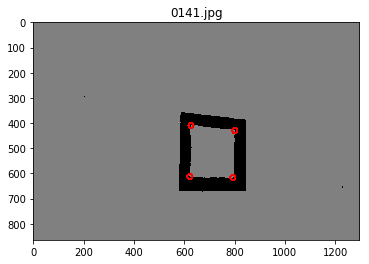

Shape: 10 Area 121176 x, y, w, h, corners: 584 175 297 408 473
Shape: 13 Area 285000 x, y, w, h, corners: 510 65 456 625 474


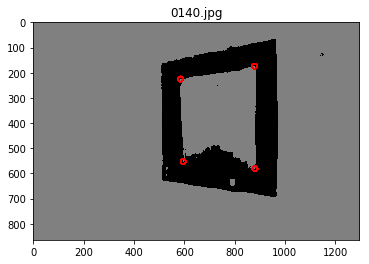

Shape: 47 Area 168438 x, y, w, h, corners: 417 270 402 419 774
Shape: 61 Area 334841 x, y, w, h, corners: 331 190 559 599 506


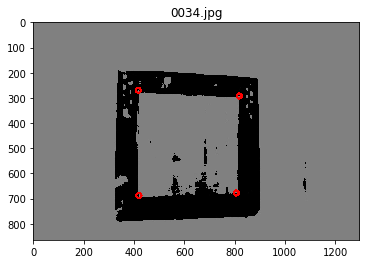

Shape: 66 Area 349980 x, y, w, h, corners: 186 135 614 570 1183


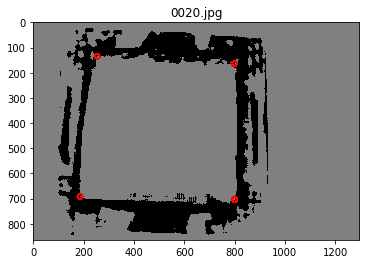

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0008.jpg


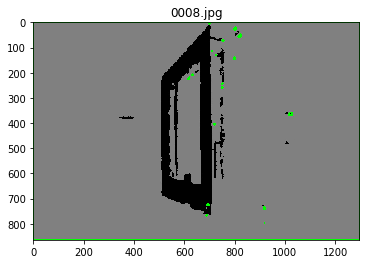

Shape: 3 Area 10626 x, y, w, h, corners: 568 455 77 138 63
Shape: 5 Area 30686 x, y, w, h, corners: 535 410 134 229 128


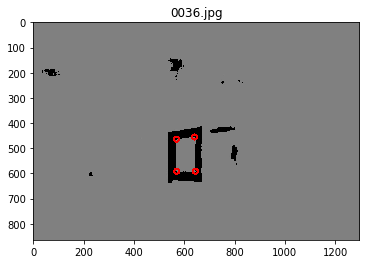

Shape: 5 Area 20368 x, y, w, h, corners: 609 340 134 152 79
Shape: 8 Area 48240 x, y, w, h, corners: 578 300 201 240 175


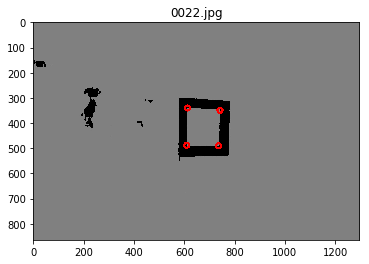

Shape: 13 Area 19888 x, y, w, h, corners: 494 378 113 176 122
Shape: 14 Area 55083 x, y, w, h, corners: 462 325 183 301 196


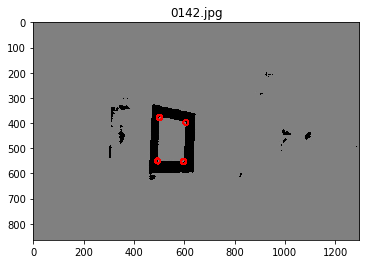

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0143.jpg


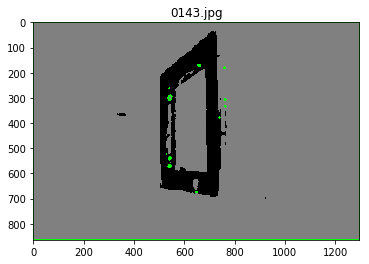

Shape: 16 Area 11232 x, y, w, h, corners: 490 355 72 156 77
Shape: 22 Area 34580 x, y, w, h, corners: 455 308 130 266 159


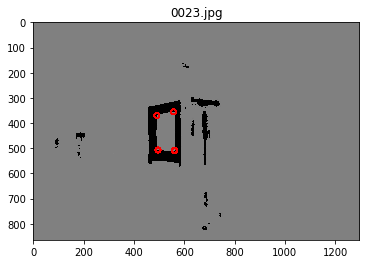

Shape: 10 Area 16059 x, y, w, h, corners: 629 357 101 159 95
Shape: 12 Area 44589 x, y, w, h, corners: 599 319 167 267 164


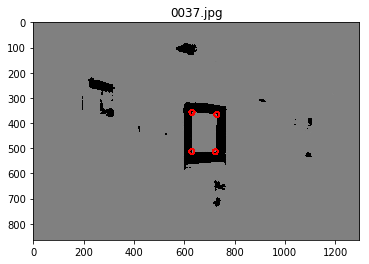

Shape: 39 Area 264020 x, y, w, h, corners: 424 80 430 614 530


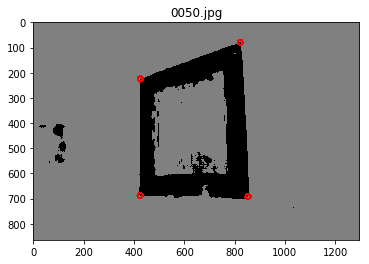

Shape: 22 Area 15604 x, y, w, h, corners: 584 418 83 188 112
Shape: 23 Area 47867 x, y, w, h, corners: 547 360 151 317 251


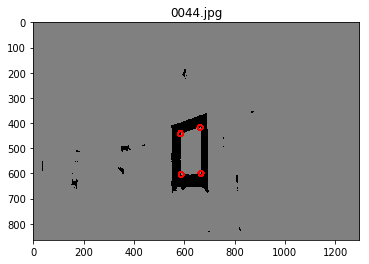

Shape: 89 Area 206091 x, y, w, h, corners: 366 194 459 449 1025
Shape: 110 Area 391707 x, y, w, h, corners: 289 111 613 639 1188


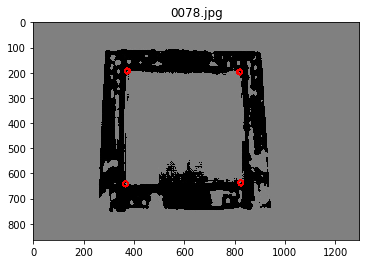

Shape: 6 Area 120879 x, y, w, h, corners: 572 283 333 363 385
Shape: 8 Area 255892 x, y, w, h, corners: 494 198 481 532 245


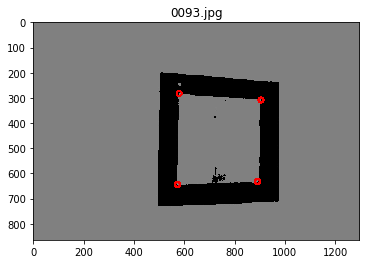

Shape: 17 Area 56145 x, y, w, h, corners: 434 350 197 285 219
Shape: 20 Area 142912 x, y, w, h, corners: 370 272 319 448 265


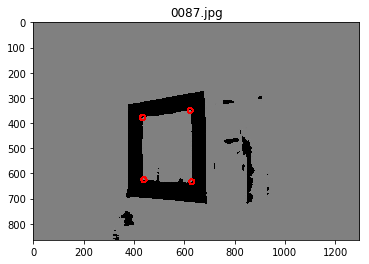

Shape: 29 Area 8700 x, y, w, h, corners: 626 469 60 145 70
Shape: 31 Area 27485 x, y, w, h, corners: 598 426 115 239 191


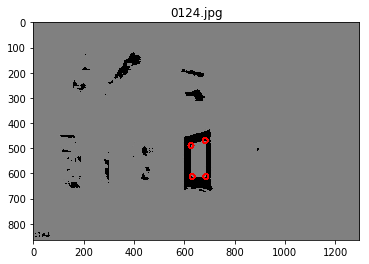

Shape: 0 Area 49729 x, y, w, h, corners: 530 321 223 223 127
Shape: 1 Area 111531 x, y, w, h, corners: 477 264 329 339 131


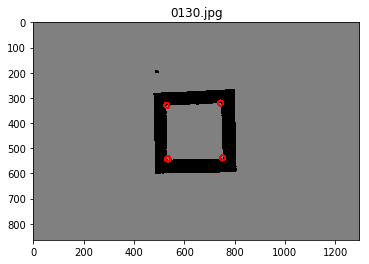

Shape: 79 Area 191264 x, y, w, h, corners: 491 77 344 556 785


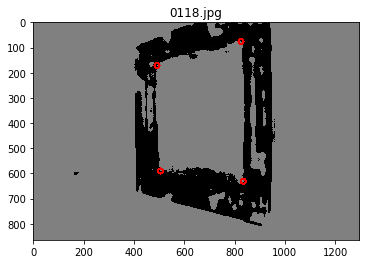

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0119.jpg


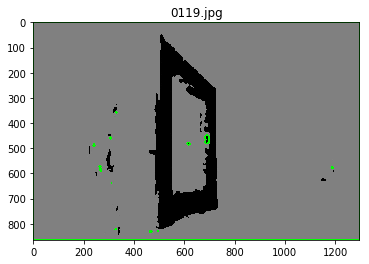

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0131.jpg


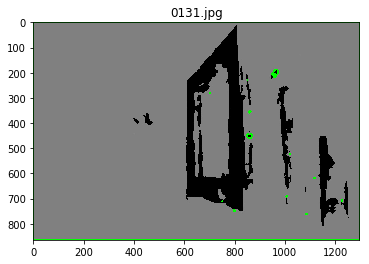

Shape: 7 Area 15105 x, y, w, h, corners: 627 436 95 159 95
Shape: 9 Area 38465 x, y, w, h, corners: 593 392 157 245 155


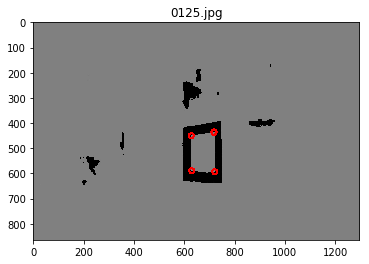

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0086.jpg


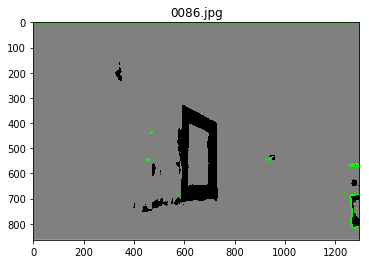

Shape: 18 Area 19662 x, y, w, h, corners: 583 388 87 226 116
Shape: 19 Area 60741 x, y, w, h, corners: 543 315 153 397 253


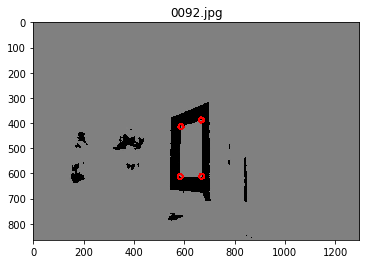

Shape: 5 Area 31161 x, y, w, h, corners: 590 308 141 221 139
Shape: 7 Area 82432 x, y, w, h, corners: 551 244 224 368 246


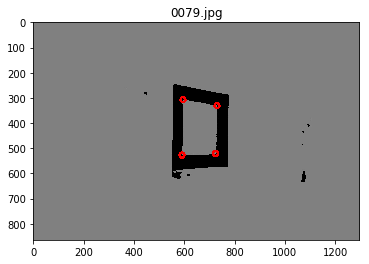

Shape: 23 Area 8960 x, y, w, h, corners: 657 470 70 128 70
Shape: 26 Area 24600 x, y, w, h, corners: 628 431 120 205 109


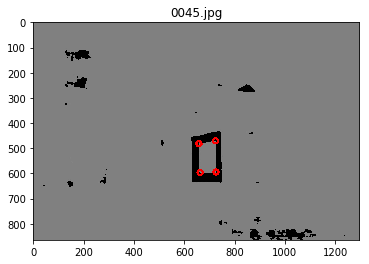

Shape: 7 Area 34579 x, y, w, h, corners: 549 386 151 229 216
Shape: 8 Area 79388 x, y, w, h, corners: 509 320 223 356 206


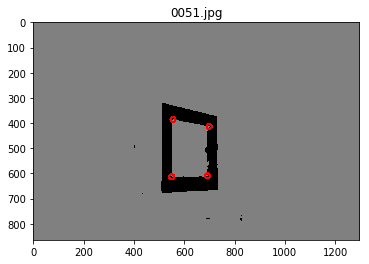

Shape: 0 Area 93808 x, y, w, h, corners: 448 361 286 328 342
Shape: 2 Area 200328 x, y, w, h, corners: 381 282 408 491 263


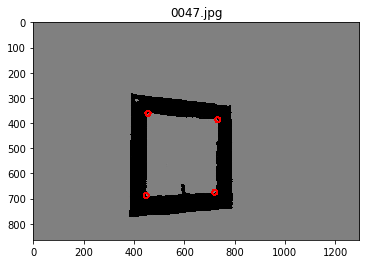

Shape: 6 Area 19203 x, y, w, h, corners: 594 442 111 173 113
Shape: 10 Area 46812 x, y, w, h, corners: 562 392 166 282 202


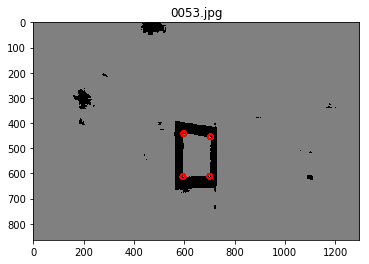

Shape: 13 Area 59670 x, y, w, h, corners: 658 258 234 255 406
Shape: 16 Area 116870 x, y, w, h, corners: 639 201 310 377 214


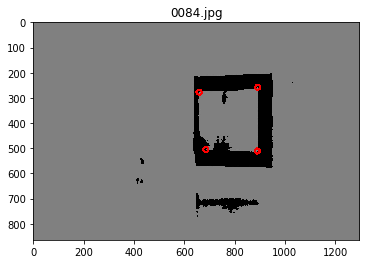

Shape: 9 Area 126074 x, y, w, h, corners: 397 305 338 373 375
Shape: 11 Area 270541 x, y, w, h, corners: 322 215 491 551 342


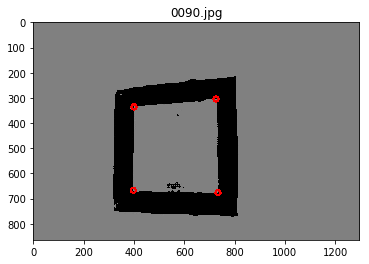

Shape: 1 Area 31816 x, y, w, h, corners: 610 419 164 194 140
Shape: 2 Area 72816 x, y, w, h, corners: 570 368 246 296 139


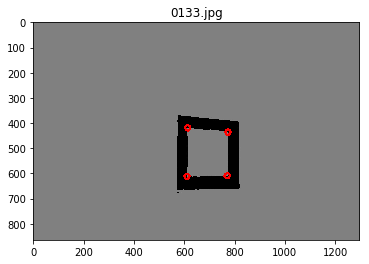

Shape: 11 Area 161112 x, y, w, h, corners: 502 198 392 411 516
Shape: 25 Area 330388 x, y, w, h, corners: 417 105 547 604 437


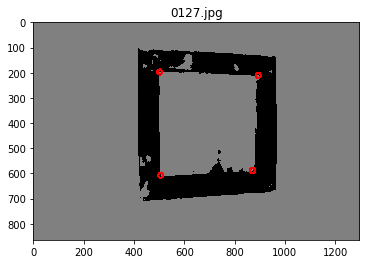

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0126.jpg


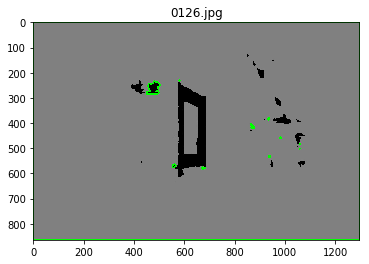

Shape: 7 Area 82008 x, y, w, h, corners: 441 346 268 306 182
Shape: 8 Area 180515 x, y, w, h, corners: 381 271 395 457 287


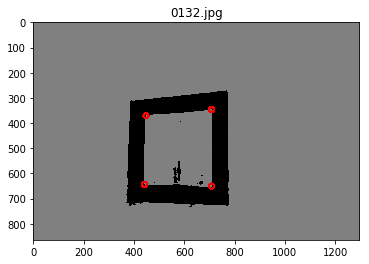

Shape: 6 Area 26364 x, y, w, h, corners: 586 433 156 169 119
Shape: 8 Area 63450 x, y, w, h, corners: 545 387 235 270 135


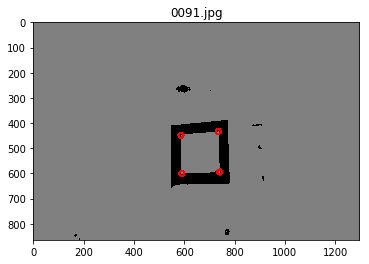

Shape: 0 Area 47080 x, y, w, h, corners: 517 403 214 220 177
Shape: 1 Area 103934 x, y, w, h, corners: 470 348 314 331 152


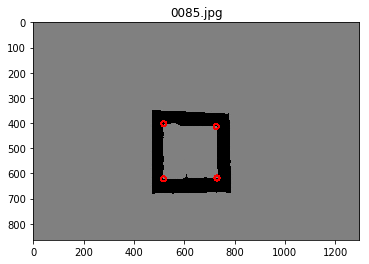

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0052.jpg


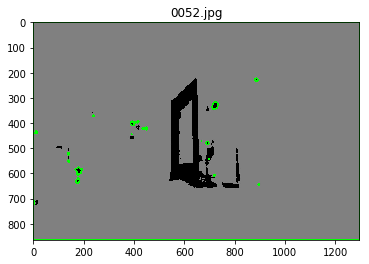

Shape: 3 Area 73038 x, y, w, h, corners: 472 330 259 282 322
Shape: 4 Area 162162 x, y, w, h, corners: 412 256 378 429 205


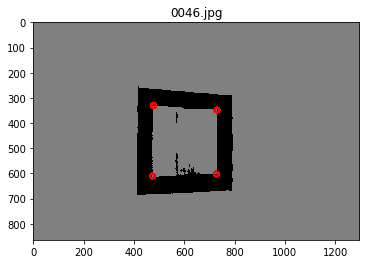

Shape: 1 Area 49950 x, y, w, h, corners: 454 378 222 225 131
Shape: 2 Area 108550 x, y, w, h, corners: 403 325 325 334 194


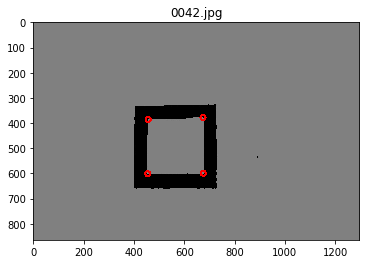

Shape: 15 Area 144400 x, y, w, h, corners: 444 239 380 380 414
Shape: 23 Area 289742 x, y, w, h, corners: 373 158 523 554 440


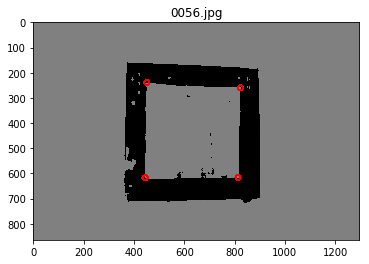

Shape: 14 Area 5504 x, y, w, h, corners: 1094 499 86 64 90
Shape: 17 Area 7832 x, y, w, h, corners: 833 456 89 88 144
Shape: 42 Area 4500 x, y, w, h, corners: 484 220 75 60 129
*** I got more than 2 shapes for a gate... 3


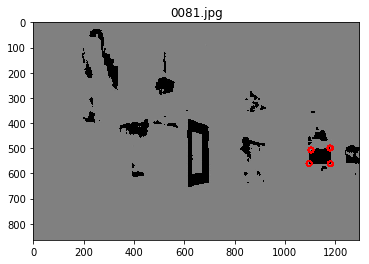

Shape: 27 Area 194068 x, y, w, h, corners: 475 162 406 478 758


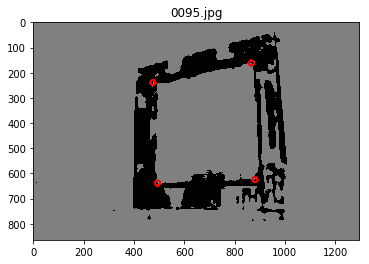

Shape: 7 Area 16485 x, y, w, h, corners: 705 398 105 157 87
Shape: 9 Area 42750 x, y, w, h, corners: 667 352 171 250 141


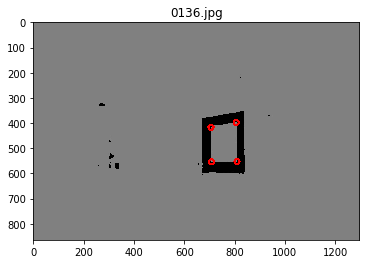

Shape: 39 Area 12393 x, y, w, h, corners: 509 434 81 153 132
Shape: 40 Area 33702 x, y, w, h, corners: 476 388 137 246 167


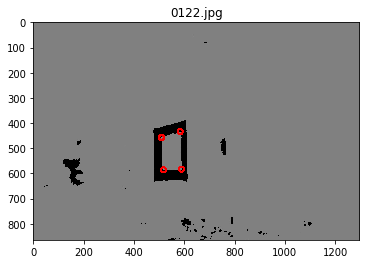

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0123.jpg


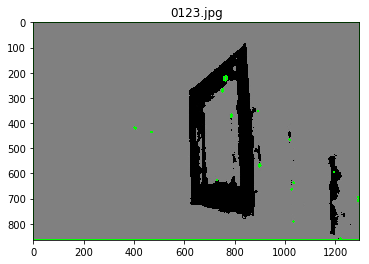

Shape: 27 Area 206414 x, y, w, h, corners: 257 183 467 442 593


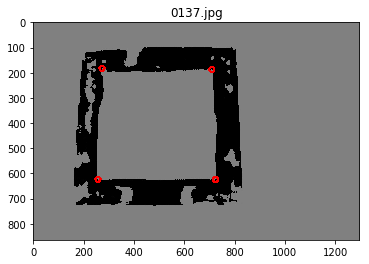

Shape: 4 Area 33294 x, y, w, h, corners: 522 391 186 179 86
Shape: 5 Area 77837 x, y, w, h, corners: 477 343 277 281 108


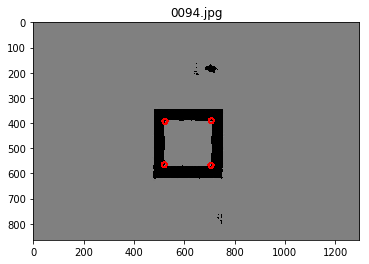

Shape: 10 Area 39951 x, y, w, h, corners: 523 384 193 207 140
Shape: 12 Area 92800 x, y, w, h, corners: 472 327 290 320 196


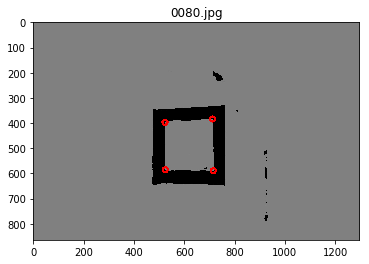

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0057.jpg


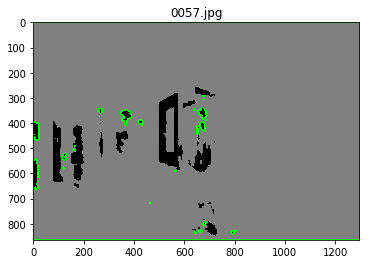

Shape: 7 Area 73437 x, y, w, h, corners: 608 326 269 273 287
Shape: 10 Area 161172 x, y, w, h, corners: 547 259 396 407 263


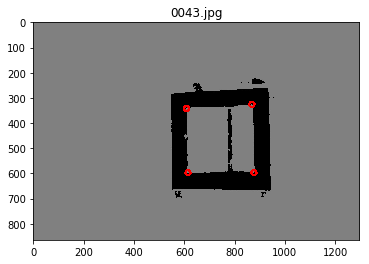

Shape: 10 Area 9765 x, y, w, h, corners: 504 387 63 155 63
Shape: 12 Area 30360 x, y, w, h, corners: 470 340 120 253 136


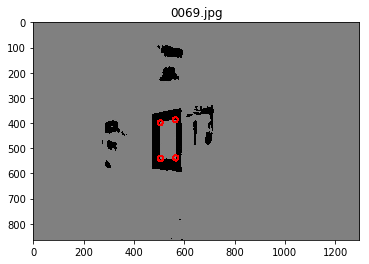

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0055.jpg


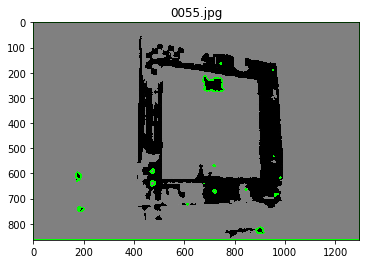

Shape: 14 Area 42390 x, y, w, h, corners: 586 323 135 314 269
Shape: 16 Area 107484 x, y, w, h, corners: 546 227 212 507 332


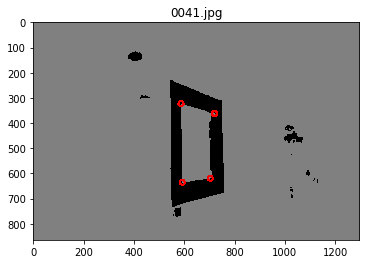

Shape: 9 Area 10640 x, y, w, h, corners: 578 459 80 133 84
Shape: 12 Area 28296 x, y, w, h, corners: 549 425 131 216 145


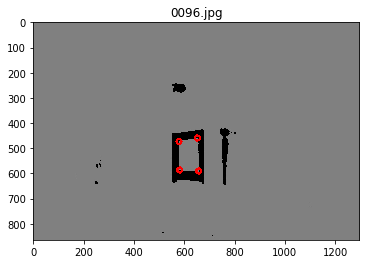

Shape: 39 Area 193519 x, y, w, h, corners: 442 227 449 431 565
Shape: 51 Area 392430 x, y, w, h, corners: 356 137 618 635 1137


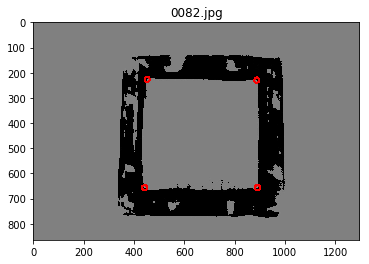

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0109.jpg


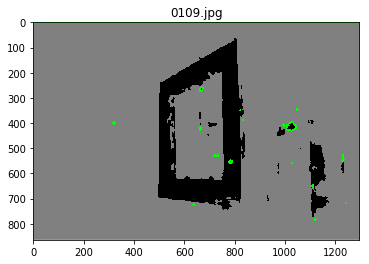

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0121.jpg


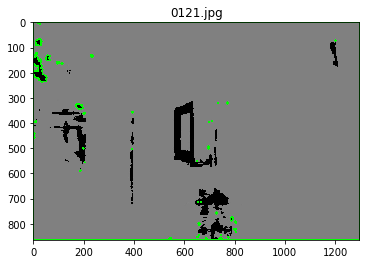

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0135.jpg


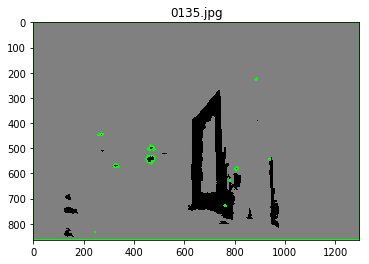

*** I got no shapes!
** No solution for: /Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/0134.jpg


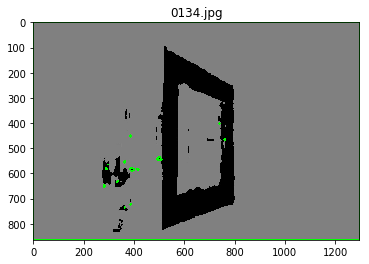

Shape: 20 Area 74360 x, y, w, h, corners: 445 354 260 286 273
Shape: 27 Area 185318 x, y, w, h, corners: 375 292 434 427 454


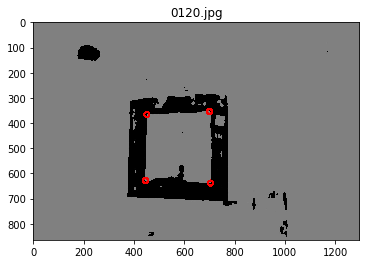

Shape: 18 Area 147441 x, y, w, h, corners: 484 231 357 413 691
Shape: 22 Area 286776 x, y, w, h, corners: 404 167 504 569 382


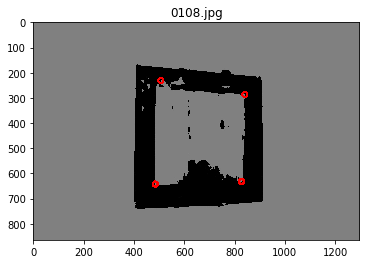

Shape: 3 Area 54395 x, y, w, h, corners: 550 303 215 253 172
Shape: 4 Area 128759 x, y, w, h, corners: 493 231 331 389 232


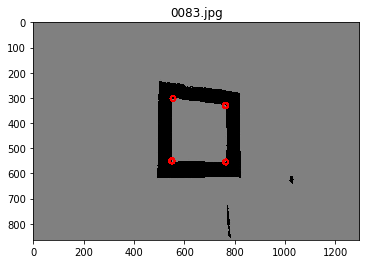

Shape: 3 Area 32448 x, y, w, h, corners: 496 375 156 208 167
Shape: 4 Area 77836 x, y, w, h, corners: 455 317 244 319 206


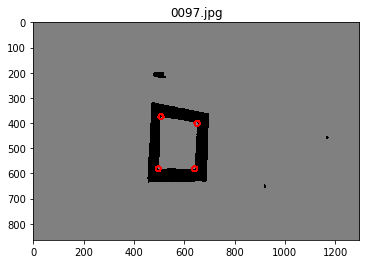

Shape: 35 Area 225225 x, y, w, h, corners: 211 190 495 455 474


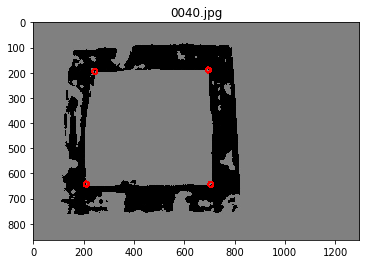

Shape: 8 Area 44772 x, y, w, h, corners: 481 362 164 273 266
Shape: 10 Area 105922 x, y, w, h, corners: 434 280 251 422 276


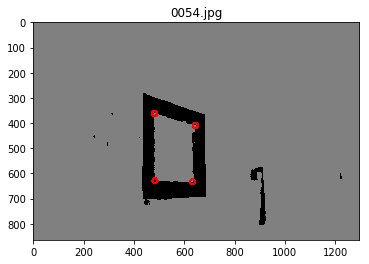

Shape: 49 Area 195264 x, y, w, h, corners: 338 149 432 452 833
Shape: 61 Area 373319 x, y, w, h, corners: 271 59 577 647 707


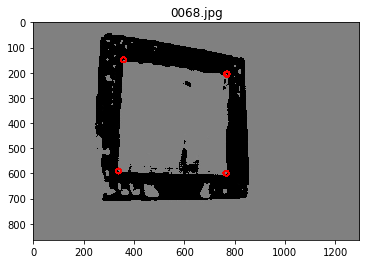

In [104]:
from matplotlib import pyplot as plt
import json
#from Corners import Corners

output_folder_path='/Users/alberto/Documents/AlphaPilot/AlphaPilot_test2/object_segmentation_pipelines/Enet/for_Alberto/'
output_image_test=output_folder_path+'0024.jpg'

class Estimator():
    
    def __init__(self):
        pass
    
    def preprocess_img(self, img_original):
        img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
        img_blur =  cv2.GaussianBlur(img_gray, (5, 5), 0)
        img_bw = cv2.threshold(img_blur,50,255,cv2.THRESH_BINARY)[1]
        
        return img_bw
    
    
    def find_shapes(self, img_bw, img_original):
        
        img_result = img_original.copy()
        results = []

        height, width = img_bw.shape[:2]

        _min_pixels_size = 60 # 100
        _max_pixels_size = height * 0.95

        #cnts = cv2.findContours(th1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cv2.findContours(img_bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        for index,c in enumerate(cnts):

            # Perform shape approximation
            epsilon = 0.1*cv2.arcLength(c,True) #0.04
            approx = cv2.approxPolyDP(c, epsilon, True)

            # 4 sides?
            if (len(approx)==4):

                cv2.drawContours(img_result, [c], -1, (0, 255, 0), 5)

                (x, y, w, h) = cv2.boundingRect(approx)
                if (w>=_min_pixels_size and h>=_min_pixels_size) and (w<_max_pixels_size and h<_max_pixels_size):

                    result = {}

                    area = w * h
                    result['area'] = area

                    print('Shape:',index,'Area', area,'x, y, w, h, corners:',x, y, w, h, len(c))


                    M = cv2.moments(c)
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])

                    result['centroid'] = (cx, cy)

                    # create mask for edge detection
                    gray = np.float32(th1)
                    mask = np.zeros(gray.shape, dtype="uint8")
                    cv2.fillPoly(mask, [approx], (255,255,255))

                    dst = cv2.cornerHarris(mask,5,3,0.04)
                    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
                    dst = np.uint8(dst)
                    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
                    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
                    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

                    result['corners'] = corners

                    results.append(result)

                    # Draw circles
                    for i in range(1, len(corners)):
                        #print(corners[i,0])
                        cv2.circle(img_result, (int(corners[i,0]), int(corners[i,1])), 10, (255,0,0), 7)

                    #print(corners)
                    
        return results, img_result
    
    def draw_points_array(image, points):
        for i in range(0, len(points)):
            cv2.circle(image, (int(points[i,0]), int(points[i,1])), 10, (255,0,0), 7)
        return image

    def get_inner_area_corners_from_results(self, results):
        try: 
            assert len(results)<3        
        except:
            print('*** I got more than 2 shapes for a gate...', len(results))
            
        try: 
            assert len(results)>0
        except: 
            print("*** I got no shapes!")
            return None
            
        if len(results) == 1: 
            inner_shape = results[0]
        else:
            inner_shape = None
            if results[0]['area'] > results[1]['area']:
                inner_shape = results[1]
            else:
                inner_shape = results[0]
        corners = inner_shape['corners'][1:]
        return corners

    
    def process_img_path(self, img_path):
        img_original = cv2.imread(img_path)
        img_bw = self.preprocess_img(img_original)
        results, img_shapes = self.find_shapes(img_bw, img_original)
        corners = self.get_inner_area_corners_from_results(results)
        
        if corners is not None:
            img_solution = draw_points_array(img_original.copy(), corners)
        else:
            print('** No solution for:',img_path)
            return None, img_shapes
        
        return corners, img_solution


estimator = Estimator()
# single image
poly, img_result = estimator.process_img_path(output_image_test)
plt.imshow(img_result)
plt.title(output_image_test)
plt.show()

# Whole folder
import os
for f in os.listdir(output_folder_path):
    #if filename.endswith(".asm") or filename.endswith(".py"): 
    poly, img_result = estimator.process_img_path(output_folder_path+f)
    plt.imshow(img_result)
    plt.title(f)
    plt.show()
    
    